### Read orginal CT and PET

In [59]:
import copy
import numpy as np
import numpy.ma as ma
import nibabel as nib
from nibabel import processing
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt

In [2]:
nii_PET = nib.load("PET_r.nii")
header_PET = nii_PET.header
affine_PET = nii_PET.affine
data_PET = nii_PET.get_fdata()

In [3]:
nii_CT = nib.load("CT_C.nii")
header_CT = nii_CT.header
affine_CT = nii_CT.affine
data_CT = nii_CT.get_fdata()

### Load 3 segmentation
1. active PET area
2. middle cavity
3. human tissue

In [13]:
nii_seg1 = nib.load("seg_1.nii.gz")
data_seg1 = nii_seg1.get_fdata()
nii_seg2 = nib.load("seg_2.nii.gz")
data_seg2 = nii_seg2.get_fdata()
nii_seg3 = nib.load("seg_3.nii.gz")
data_seg3 = nii_seg3.get_fdata()
nii_seg4 = nib.load("seg_4.nii.gz")
data_seg4 = nii_seg4.get_fdata()

In [14]:
imgx, imgy, imgz = data_PET.shape
print(imgx,imgy,imgz)

512 512 47


1. real CT
2. middle cavity
3. human tissue
4. PET ball

In [76]:
ravel_m1 = []
ravel_m2 = []
ravel_m3 = []
ravel_m4 = []
data_seg = data_PET

for idx in range(imgx):
    for idy in range(imgy):
        for idz in range(imgz):
            if data_seg1[idx, idy, idz] == 1:
                ravel_m1.append(data_seg[idx, idy, idz])
            if data_seg2[idx, idy, idz] == 1:
                ravel_m2.append(data_seg[idx, idy, idz])
            if (data_seg3[idx, idy, idz] == 3)and\
               (data_seg2[idx, idy, idz] != 1)and\
               (data_seg1[idx, idy, idz] != 1):
                ravel_m3.append(data_seg[idx, idy, idz])
            if data_seg4[idx, idy, idz] == 1:
                ravel_m4.append(data_seg[idx, idy, idz])

ravel_m1 = np.array(ravel_m1)
ravel_m2 = np.array(ravel_m2)
ravel_m3 = np.array(ravel_m3)
ravel_m4 = np.array(ravel_m4)
print(ravel_m1.shape, ravel_m2.shape, ravel_m3.shape, ravel_m4.shape)

(19351,) (62296,) (1326882,) (12839,)


Text(0.5, 1.0, 'Seg4')

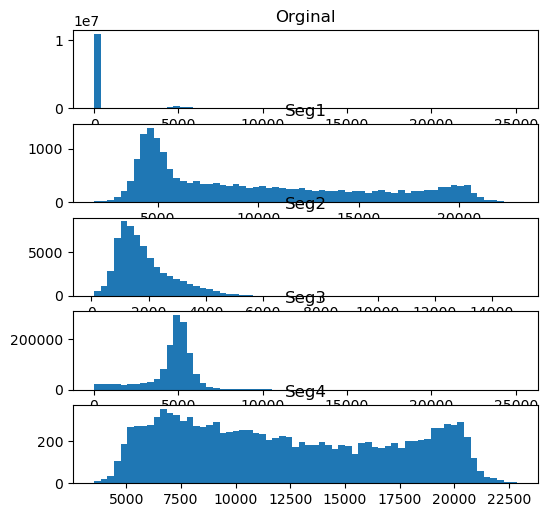

In [70]:
plt.figure(figsize=(6,6), dpi=100)
plt.subplot(5,1,1)
plt.hist(np.ravel(data_PET), bins=64)
plt.title("Orginal")
plt.subplot(5,1,2)
plt.hist(ravel_m1, bins=64)
plt.title("Seg1")
plt.subplot(5,1,3)
plt.hist(ravel_m2, bins=64)
plt.title("Seg2")
plt.subplot(5,1,4)
plt.hist(ravel_m3, bins=64)
plt.title("Seg3")
plt.subplot(5,1,5)
plt.hist(ravel_m4, bins=64)
plt.title("Seg4")

In [71]:
mu_m1 = np.mean(ravel_m1)
mu_m2 = np.mean(ravel_m2)
mu_m3 = np.mean(ravel_m3)
mu_m4 = np.mean(ravel_m4)

sigma_m1 = np.var(ravel_m1)
sigma_m2 = np.var(ravel_m2)
sigma_m3 = np.var(ravel_m3)
sigma_m4 = np.var(ravel_m4)

print(mu_m1, sigma_m1)
print(mu_m2, sigma_m2)
print(mu_m3, sigma_m3)
print(mu_m4, sigma_m4)

9806.224106591158 29785022.52613664
1838.2496923716335 988508.0460431965
4585.81028873277 1999247.0715178258
12310.002868970854 24749059.869613852


In [72]:
print(np.percentile(ravel_m1, q=1), np.percentile(ravel_m1, q=99))
print(np.percentile(ravel_m2, q=1), np.percentile(ravel_m2, q=99))
print(np.percentile(ravel_m3, q=1), np.percentile(ravel_m3, q=99))
print(np.percentile(ravel_m4, q=1), np.percentile(ravel_m4, q=99))
print()
print(np.percentile(ravel_m1, q=0), np.percentile(ravel_m1, q=100))
print(np.percentile(ravel_m2, q=0), np.percentile(ravel_m2, q=100))
print(np.percentile(ravel_m3, q=0), np.percentile(ravel_m3, q=100))
print(np.percentile(ravel_m4, q=0), np.percentile(ravel_m4, q=100))

min_m1 = np.percentile(ravel_m1, q=1)
min_m2 = np.percentile(ravel_m2, q=1)
min_m3 = np.percentile(ravel_m3, q=1)
min_m4 = np.percentile(ravel_m4, q=1)

max_m1 = np.percentile(ravel_m1, q=99)
max_m2 = np.percentile(ravel_m2, q=99)
max_m3 = np.percentile(ravel_m3, q=99)
max_m4 = np.percentile(ravel_m4, q=99)

3163.8289794921875 20887.2666015625
342.9103546142578 4821.379272460939
270.4205401611328 7165.526870117186
4617.538828125 21086.862929687493

1835.63720703125 22851.53125
91.75639343261719 14870.4365234375
4.384741306304932 25065.80859375
3522.948486328125 22851.53125


### Create syn CT-like PET

In [79]:
data_CT_syn = np.zeros(data_PET.shape)
ravel_m1_syn = np.random.normal(mu_m4, sigma_m4, len(ravel_m1))
ravel_m2_syn = np.random.normal(mu_m2, sigma_m2, len(ravel_m2))
ravel_m3_syn = np.random.normal(mu_m3, sigma_m3, len(ravel_m3))
ravel_m1_syn[ravel_m1_syn<min_m4] = np.min(min_m4)
ravel_m2_syn[ravel_m2_syn<min_m2] = np.min(min_m2)
ravel_m3_syn[ravel_m3_syn<min_m3] = np.min(min_m3)
ravel_m1_syn[ravel_m1_syn>max_m4] = np.max(max_m4)
ravel_m2_syn[ravel_m2_syn>max_m2] = np.max(max_m2)
ravel_m3_syn[ravel_m3_syn>max_m3] = np.max(max_m3)
point_m1 = 0
point_m2 = 0
point_m3 = 0

In [80]:
for idx in range(imgx):
    for idy in range(imgy):
        for idz in range(imgz):
            if data_seg1[idx, idy, idz] == 1:
                data_CT_syn[idx, idy, idz] = ravel_m1_syn[point_m1]
                point_m1 += 1
            if data_seg2[idx, idy, idz] == 1:
                data_CT_syn[idx, idy, idz] = ravel_m2_syn[point_m2]
                point_m2 += 1
            if (data_seg3[idx, idy, idz] == 3)and\
               (data_seg2[idx, idy, idz] != 1)and\
               (data_seg1[idx, idy, idz] != 1):
                data_CT_syn[idx, idy, idz] = ravel_m3_syn[point_m3]
                point_m3 += 1

In [63]:
nii_CT_syn = nib.Nifti1Image(data_CT_syn, affine_CT, header_CT)
nii_CT_syn_smooth = processing.smooth_image(nii_CT_syn, fwhm=3, mode='nearest')
nib.save(nii_CT_syn_smooth, "CT_syn_stick.nii")